# Julia Deep Learning

https://fluxml.ai/

https://github.com/FluxML/model-zoo

In [1]:
using Flux
using CuArrays
using Plots
using Plots.PlotMeasures

CuArrays.allowscalar(false)

pyplot()

┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/cavani/Workspace/julia-abc/software/julia-env/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


Plots.PyPlotBackend()

## MNIST Dataset

In [2]:
function load_mnist(split_name)
    mnist = Flux.Data.MNIST
    
    images = mnist.images(split_name) # Array with N images of 28x28 8-bits gray
    labels = mnist.labels(split_name) # Array with N labels scalar 0-9
    
    return (images=images, labels=labels)
end

train_data = load_mnist(:train)
test_data = load_mnist(:test)

println("Train images:\n",
        "\ntype = ", typeof(train_data.images),
        "\nsize = ", size(train_data.images),
        "\nshape = ", size(train_data.images[1]),
        "\n")
println("Train labels:\n",
        "\ntype = ", typeof(train_data.labels),
        "\nsize = ", size(train_data.labels),
        "\n\n")

println("Test images:\n",
        "\ntype = ", typeof(test_data.images),
        "\nsize = ", size(test_data.images),
        "\nshape = ", size(test_data.images[1]),
        "\n")
println("Test labels:\n",
        "\ntype = ", typeof(test_data.labels),
        "\nsize = ", size(test_data.labels))

Train images:

type = Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}
size = (60000,)
shape = (28, 28)

Train labels:

type = Array{Int64,1}
size = (60000,)


Test images:

type = Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}
size = (10000,)
shape = (28, 28)

Test labels:

type = Array{Int64,1}
size = (10000,)


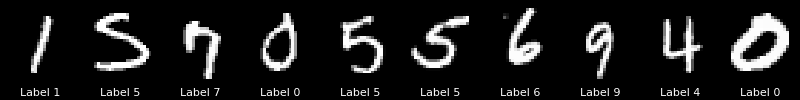

In [3]:
plot_digit(image, label) = plot(image, xlabel=(label !== nothing ? "Label $(label)" : ""),
                                guidefontsize=8, legend=false, margin=0mm, link=:both,
                                ticks=nothing, border=:none)
function plot_digits(images, labels=nothing; size=(800, 100), layout=(1, length(images)))
    plots = map(1:prod(layout)) do i
        image = images[i]
        label = labels !== nothing ? labels[i] : nothing
        plot_digit(image, label)
    end
    plot(plots..., layout=layout, size=size, bg_color="black", fg_color="white")
end

function sample(data, size=10)
    indices = rand(1:length(data.images), 10)
    images = data.images[indices]
    labels = data.labels[indices]
    return (images=images, labels=labels)
end

train_sample = sample(train_data)
plot_digits(train_sample...)

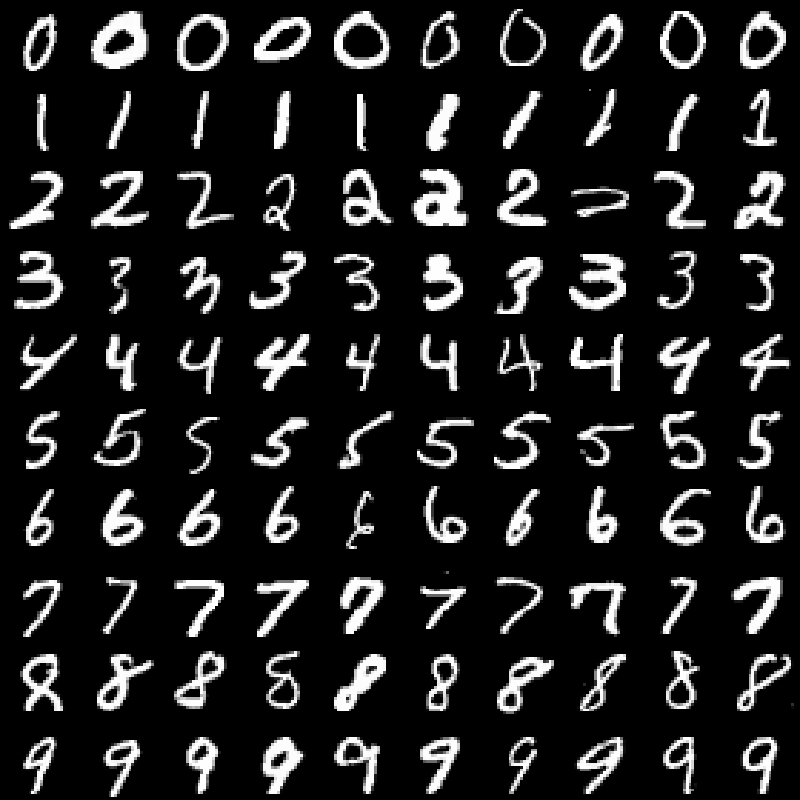

In [4]:
function sample_classes(data, sample_size_per_class=10)
    class_vector = sort(unique(data.labels))
    samples = map(class_vector) do label
        label_indices = findall(==(label), data.labels)
        sample_indices = rand(label_indices, sample_size_per_class)
        images = data.images[sample_indices]
        images
    end
    return samples
end

train_sample2 = sample_classes(train_data)
plot_digits(vcat(train_sample2...); size=(800, 800), layout=(10, 10))

In [5]:
function compute_num_channels(image)
    color_type = eltype(image)
    if color_type <: Gray
        return 1
    elseif color_type <: RGB
        return 3
    else
        error("Unknown color type: $(color_type)")
    end
end

function make_whcn_format(images)
    width, height = size(images[1])
    num_channels = compute_num_channels(images[1])
    batch_size = length(images)
    @assert num_channels == 1 # only Gray -> Foloat32 supported

    images_tensor = Array{Float32, 4}(undef, width, height, num_channels, batch_size)
    for (batch_index, image) in enumerate(images)
        images_tensor[:, :, :, batch_index] = Float32.(reshape(image, width, height, num_channels))
    end
    return images_tensor
end

X_whcn = make_whcn_format(train_sample.images)
println("X (WHCN format):\n",
        "\ntype = ", typeof(X_whcn),
        "\nsize = ", size(X_whcn),
        "\n")

X (WHCN format):

type = Array{Float32,4}
size = (28, 28, 1, 10)



In [6]:
import Flux: onehot

function make_onehot_format(labels, class_vector)
    num_labels = length(class_vector)
    batch_size = length(labels)
    
    labels_tensor = Array{Float32, 2}(undef, num_labels, batch_size)
    for (batch_index, label) in enumerate(labels)
        labels_tensor[:, batch_index] = Float32.(onehot(label, class_vector))
    end
    return labels_tensor
end

y_onehot = make_onehot_format(train_sample.labels, 0:9)
println("y (One Hot format):\n",
        "\ntype = ", typeof(y_onehot),
        "\nsize = ", size(y_onehot),
        "\n")

y (One Hot format):

type = Array{Float32,2}
size = (10, 10)



In [7]:
import Base.Iterators: partition

function make_batch(images, labels)
    X = make_whcn_format(images)
    y = make_onehot_format(labels, 0:9)
    return (X=X, y=y)
end

function make_dataset(images, labels; batch_size)
    batch_size == 0 && return make_batch(images, labels)
    
    num_examples = length(images)
    num_batches = ceil(Int, num_examples / batch_size)
    batch_indices = partition(1:num_examples, batch_size)
    batches = map(batch_indices) do indices
        make_batch(images[indices], labels[indices])
    end
    return batches
end

dataset_train = make_dataset(train_data...; batch_size=256)
dataset_test = make_dataset(test_data...; batch_size=0)

println("Train\n")
println("Number of batches   : ", length(dataset_train))
println("First batch X shape : ", size(dataset_train[1].X))
println("First batch y shape : ", size(dataset_train[1].y))
println("Last batch X shape  : ", size(dataset_train[end].X))
println("Last batch y shape  : ", size(dataset_train[end].y))
println("\n")
println("Test\n")
println("X shape             : ", size(dataset_test.X))
println("y shape             : ", size(dataset_test.y))

Train

Number of batches   : 235
First batch X shape : (28, 28, 1, 256)
First batch y shape : (10, 256)
Last batch X shape  : (28, 28, 1, 96)
Last batch y shape  : (10, 96)


Test

X shape             : (28, 28, 1, 10000)
y shape             : (10, 10000)


## Extra API

In [8]:
flatten(x) = reshape(x, :, size(x)[end])

struct Reshape
    dims
end

(layer::Reshape)(x) = reshape(x, layer.dims..., size(x)[end])

## MLP

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl

In [9]:
function make_mlp(input_size, output_size, hidden_size; use_gpu=true)
    model = Chain(
        flatten,
        Dense(input_size, hidden_size, relu),
        Dense(hidden_size, output_size),
        softmax,
    )
    if use_gpu
        model = gpu(model)
    end
    return model
end

mlp_input_size = 28 * 28 * 1
mlp_output_size = 10
mlp_hidden_size = 500

mlp = make_mlp(mlp_input_size, mlp_output_size, mlp_hidden_size)

mlp

Chain(flatten, Dense(784, 500, relu), Dense(500, 10), softmax)

In [10]:
X1, y1 = gpu(dataset_train[1])
ŷ1 = mlp(X1)

10×256 CuArray{Float32,2,Nothing}:
 0.115953   0.0512035  0.0636685  …  0.0752501  0.0815788  0.16527
 0.0809422  0.063311   0.0773606     0.0452272  0.0753812  0.0419149
 0.0976691  0.0997462  0.048121      0.0608771  0.159908   0.104625
 0.118153   0.0836975  0.129937      0.0919707  0.106954   0.0924347
 0.0997881  0.194671   0.156687      0.254301   0.146868   0.0976688
 0.105741   0.10952    0.159321   …  0.0766297  0.094231   0.113609
 0.075342   0.0988169  0.158495      0.0895938  0.0849764  0.102459
 0.0643124  0.0748246  0.062101      0.155106   0.0688271  0.0688073
 0.142566   0.126121   0.0630584     0.0571354  0.118296   0.13475
 0.0995336  0.0980875  0.0812511     0.0939098  0.0629801  0.0784617

In [11]:
import Flux: logitcrossentropy, onecold
import Statistics: mean

function crossentropy(model, x, y)
    logits = model[1:end-1](x)
    return logitcrossentropy(logits, y)
end

function accuracy(model, x, y)
    ŷ = model(x)
    return mean(onecold(cpu(ŷ)) .== onecold(cpu(y)))
end


loss_train = crossentropy(mlp, X1, y1)
metric_train = accuracy(mlp, X1, y1)

println("Train (batch 1)\n")    
println("Loss     : ", loss_train)
println("Accuracy : ", metric_train)

Train (batch 1)

Loss     : 2.3406096
Accuracy : 0.0859375


In [12]:
import Flux: train!
import BSON: bson
import Printf: @printf

make_loss(model) = (x, y) -> crossentropy(model, x, y)

make_metric(model) = (x, y) -> accuracy(model, x, y)

function run_train(model, train_data, eval_data;
                   optimizer=ADAM(0.001), num_epochs=100,
                   model_file="model.bson")
    loss = make_loss(model)
    metric = make_metric(model)

    best_metric = 0.0
    last_improvement = 0
    for epoch_idx in 1:num_epochs
        # Train for a single epoch
        for i in 1:length(train_data)
            let data = gpu(train_data[i])
                train!(loss, params(model), [data], optimizer)
            end
        end

        # Calculate accuracy:
        metric_eval = let data = gpu(eval_data)
            metric(data...)
        end

        @printf("[%d] Test accuracy: %.4f\n", epoch_idx, metric_eval)

        # If our metric is good enough, quit out.
        if metric_eval >= 0.999
            println(" -> Early-exiting: We reached our target accuracy of 99.9%")
            break
        end

        # If this is the best accuracy we've seen so far, save the model out
        if metric_eval >= best_metric
            println(" -> New best accuracy! Saving model out to $(model_file)")
            bson(model_file, model = cpu(model), epoch = epoch_idx, accuracy = metric_eval)
            best_metric = metric_eval
            last_improvement = epoch_idx
        end

        # If we haven't seen improvement in 5 epochs, drop our learning rate:
        if epoch_idx - last_improvement >= 5 && optimizer.eta > 1e-6
            optimizer.eta /= 10.0
            println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

            # After dropping learning rate, give it a few epochs to improve
            last_improvement = epoch_idx
        end

        if epoch_idx - last_improvement >= 10
            println(" -> We're calling this converged.")
            break
        end
    end
end

run_train(mlp, dataset_train, dataset_test; model_file="mlp_mnist.bson")

[1] Test accuracy: 0.9506
 -> New best accuracy! Saving model out to mlp_mnist.bson
[2] Test accuracy: 0.9648
 -> New best accuracy! Saving model out to mlp_mnist.bson
[3] Test accuracy: 0.9693
 -> New best accuracy! Saving model out to mlp_mnist.bson
[4] Test accuracy: 0.9708
 -> New best accuracy! Saving model out to mlp_mnist.bson
[5] Test accuracy: 0.9719
 -> New best accuracy! Saving model out to mlp_mnist.bson
[6] Test accuracy: 0.9734
 -> New best accuracy! Saving model out to mlp_mnist.bson
[7] Test accuracy: 0.9748
 -> New best accuracy! Saving model out to mlp_mnist.bson
[8] Test accuracy: 0.9762
 -> New best accuracy! Saving model out to mlp_mnist.bson
[9] Test accuracy: 0.9768
 -> New best accuracy! Saving model out to mlp_mnist.bson
[10] Test accuracy: 0.9768
 -> New best accuracy! Saving model out to mlp_mnist.bson
[11] Test accuracy: 0.9773
 -> New best accuracy! Saving model out to mlp_mnist.bson
[12] Test accuracy: 0.9782
 -> New best accuracy! Saving model out to mlp_

In [13]:
mlp = nothing
X1 = nothing
y1 = nothing
ŷ1 = nothing
GC.gc()

In [14]:
import BSON: load

function load_model(model_file; use_gpu=true)
    model = load("mlp_mnist.bson")[:model]
    if use_gpu
        model = gpu(model)
    end
    return model
end

function evaluate(model, eval_data)
    loss = make_loss(model)
    metric = make_metric(model)

    data = gpu(eval_data)
    loss_eval = loss(data...)
    metric_eval = metric(data...)

    println("Evaluation\n")
    println("Loss     : ", loss_eval)
    println("Accuracy : ", metric_eval)
end

best_mlp = load_model("mlp_mnist.bson")
evaluate(best_mlp, dataset_test)

Evaluation

Loss     : 0.074446715
Accuracy : 0.983


In [15]:
best_mlp = nothing

GC.gc()

## CNN

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl

In [ ]:
input_size = MNISTspec.input_size
output_size = MNISTspec.num_classes

conv1_kernel_size = (3, 3)
conv1_filter_size = input_size[end] => 16
conv1_pad = (1, 1)
pool1_size = (2, 2)

conv2_kernel_size = (3, 3)
conv2_filter_size = conv1_filter_size.second => 32
conv2_pad = (1, 1)
pool2_size = (2, 2)

conv3_kernel_size = (3, 3)
conv3_filter_size = conv2_filter_size.second => 32
conv3_pad = (1, 1)
pool3_size = (2, 2)

fc1_size = prod(input_size[1:2] .÷ pool1_size .÷ pool2_size .÷ pool3_size) * conv3_filter_size.second

model = Chain(
    Conv(conv1_kernel_size, conv1_filter_size, pad=conv1_pad, relu),
    MaxPool(pool1_size),

    Conv(conv2_kernel_size, conv2_filter_size, pad=conv2_pad, relu),
    MaxPool(pool2_size),

    Conv(conv3_kernel_size, conv3_filter_size, pad=conv3_pad, relu),
    MaxPool(pool3_size),
    
    Flatten(),
    Dense(fc1_size, output_size),
    softmax,
)

model = gpu(model)

model

In [ ]:
let
    x1 = gpu(train_data[1][1])
    display(model(x1))
end

In [ ]:
import Flux: logitcrossentropy, onecold
import Statistics: mean

function loss_noise(x, y)
    x_aug = x .+ 0.1f0 * gpu(randn(eltype(x), size(x)))
    logits = model[1:end-1](x)
    return logitcrossentropy(logits, y)
end

function accuracy(x, y)
    ŷ = model(x)
    return mean(onecold(cpu(ŷ)) .== onecold(cpu(y)))
end


let
    println("Train (batch 1)\n")
    
    data1 = gpu(train_data[1])
    loss_ = loss_noise(data1...)
    acc_ = accuracy(data1...)

    println("Loss: ", loss_)
    println("Accuracy: ", acc_)
end

In [ ]:
import Flux: train!
import BSON: bson
import Printf: @printf

optimizer = ADAM(0.001)

best_acc = 0.0
last_improvement = 0
for epoch_idx in 1:100
    # Train for a single epoch
    for i in 1:length(train_data)
        let data = gpu(train_data[i])
            train!(loss_noise, params(model), [data], optimizer)
        end
    end
    
    # Calculate accuracy:
    acc = let data = gpu(test_data)
        accuracy(data...)
    end
    
    @printf("[%d] Test accuracy: %.4f\n", epoch_idx, acc)
    
    # If our accuracy is good enough, quit out.
    if acc >= 0.999
        println(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        println(" -> New best accuracy! Saving model out to cnn_mnist.bson")
        bson("cnn_mnist.bson", model = cpu(model), epoch = epoch_idx)
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && optimizer.eta > 1e-6
        optimizer.eta /= 10.0
        println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        println(" -> We're calling this converged.")
        break
    end
end

In [ ]:
model = nothing

GC.gc()

In [ ]:
import BSON: load

model = load("cnn_mnist.bson")[:model]
model = gpu(model)

model

In [ ]:
let
    println("Test\n")

    data = gpu(test_data)
    loss_ = loss_noise(data...)
    acc_ = accuracy(data...)

    println("Loss: ", loss_)
    println("Accuracy: ", acc_)
end

## Autoencoder

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/autoencoder.jl

In [ ]:
input_size = MNISTspec.input_size
hidden_size = 500
encoded_size = 50

encoder = Chain(
    Flatten(),
    Dense(prod(input_size), hidden_size, leakyrelu),
    Dense(hidden_size, encoded_size, leakyrelu),
)

decoder = Chain(
    Dense(encoded_size, hidden_size, leakyrelu),
    Dense(hidden_size, prod(input_size), leakyrelu),
    Reshape(input_size),
)

model = Chain(encoder, decoder)

model = gpu(model)

model

In [ ]:
let
    x1 = gpu(train_data[1][1])
    x̂1 = model(x1)
    println("x : type=$(typeof(x1)), size=$(size(x1))")
    println("x̂ : type=$(typeof(x̂1)), size=$(size(x̂1))")
end

In [ ]:
function loss(x)
    x̂ = model(x)
    err = x̂ .- x
    N = length(x)
    return sum(err .* err) / N
end

let
    println("Train (batch 1)\n")
    x1 = gpu(train_data[1][1])
    loss_ = loss(x1)
    println("Loss: ", loss_)
end

println()

let
    println("Test\n")
    data = gpu(test_data[1])
    loss_ = loss(data)
    println("Loss: ", loss_)
end

In [ ]:
import Flux: train!
import BSON: bson
import Printf: @printf

optimizer = ADAM(0.001)

best_loss = Inf
last_improvement = 0
for epoch_idx in 1:100
    # Train for a single epoch
    for i in 1:length(train_data)
        let data = gpu(train_data[i][1])
            train!(loss, params(model), [(data,)], optimizer)
        end
    end
    
    # Calculate accuracy:
    loss_ = let data = gpu(test_data[1])
        loss(data)
    end
    
    @printf("[%d] Test loss: %.4f\n", epoch_idx, loss_)
    
    # If this is the best accuracy we've seen so far, save the model out
    if loss_ <= best_loss
        println(" -> New best loss! Saving model out to ae_mnist.bson")
        bson("ae_mnist.bson", model = cpu(model), epoch = epoch_idx)
        best_loss = loss_
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && optimizer.eta > 1e-6
        optimizer.eta /= 10.0
        println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        println(" -> We're calling this converged.")
        break
    end
end

In [ ]:
model = nothing

GC.gc()

In [ ]:
import BSON: load

model = load("ae_mnist.bson")[:model]
model = gpu(model)

model

In [ ]:
let
    println("Test\n")
    data = gpu(test_data[1])
    loss_ = loss(data)
    println("Loss: ", loss_)
end